In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import networkx as nx
from ast import literal_eval

In [2]:
import geopy.distance

In [32]:
from sklearn.preprocessing import LabelEncoder

In [67]:
import pickle

# Process Graph

In [40]:
with open('data/new_bus_transport_graph_new_dist.json', 'r') as fileobj:
    js_graph = json.load(fileobj)
G = nx.readwrite.json_graph.node_link_graph(js_graph)

In [41]:
len(G.nodes())

5083

In [5]:
G.nodes['75009']

{'type': 'bus_stop',
 'latitude': 1.35407552367477,
 'longitude': 103.94339098473914,
 'planningArea': 'TAMPINES',
 'tap_in': 4607736,
 'tap_out': 4502560,
 'deficit': 105176,
 'avg_flow': 4555148,
 'pop_multiplier': 0.1901251020089246,
 'pop_estimate': 49413}

In [6]:
G.edges[('75009', '76059')]

{'type': 'bus_bus',
 'weight': 0.6,
 'AM_Offpeak_Freq': 1301.142857142857,
 'AM_Peak_Freq': 178.85714285714283,
 'PM_Offpeak_Freq': 224.7142857142857,
 'PM_Peak_Freq': 312.57142857142856}

In [7]:
G.edges[('01012', '01112')]

{'type': 'bus_bus',
 'weight': 0.5,
 'AM_Offpeak_Freq': 760.4285714285714,
 'AM_Peak_Freq': 126.14285714285714,
 'PM_Offpeak_Freq': 175.28571428571428,
 'PM_Peak_Freq': 245.8571428571429}

In [51]:
# G.edges()[('99189','98101')]  # not a direct connection, should throw error if G is defined correctly

In [8]:
stop_pair_info = pd.read_csv('results/full_bus_ttt_default_calcs.csv')
stop_pair_info.head()

,orig,dest,freq_type,avg_trips,best_buses,best_parallelized_time,all_candidates,ttt_contribution,dist_m,ttt_pm
0,1012,1112,AM_Offpeak_Freq,760.428571,"{'7', '175', '63', '12', '12e', '80'}",86.505551,"{'12': {'travel': 90.0, 'wait': 345.0, 'total'...",65781.292217,500,131.562584
1,1012,1112,AM_Peak_Freq,126.142857,"{'7', '175', '63', '12', '12e', '80'}",70.070728,"{'12': {'travel': 90.0, 'wait': 300.0, 'total'...",8838.921774,500,17.677844
2,1012,1112,PM_Offpeak_Freq,175.285714,"{'7', '175', '63', '12', '12e', '80'}",93.051703,"{'12': {'travel': 90.0, 'wait': 360.0, 'total'...",16310.634185,500,32.621268
3,1012,1112,PM_Peak_Freq,245.857143,"{'7', '175', '63', '12', '12e', '80'}",83.038050,"{'12': {'travel': 90.0, 'wait': 330.0, 'total'...",20415.497656,500,40.830995
4,1012,1113,AM_Offpeak_Freq,438.142857,"{'32', '2', '33', '2A', '51', '61'}",88.426798,"{'2': {'travel': 108.0000000000001, 'wait': 39...",38743.569743,600,64.572616


In [9]:
stop_pair_info.groupby(['orig', 'dest'])[['best_parallelized_time', 'dist_m']].mean().reset_index()

,orig,dest,best_parallelized_time,dist_m
0,1012,1112,83.166508,500
1,1012,1113,89.068530,600
2,1012,1121,54.288566,1056
3,1012,1211,60.280502,1411
4,1012,1311,66.250678,1767
...,...,...,...,...
321769,99189,98101,1282.000000,4956
321770,99189,98239,252.887531,3589
321771,99189,99029,178.648815,1211
321772,99189,99039,138.049379,856


In [10]:
stop_pair_info.groupby(['orig', 'dest'])[['avg_trips', 'ttt_contribution', 'ttt_pm']].mean().reset_index()

,orig,dest,avg_trips,ttt_contribution,ttt_pm
0,1012,1112,326.928571,27836.586458,55.673173
1,1012,1113,226.821429,20143.966079,33.573277
2,1012,1121,150.000000,8296.703023,7.856726
3,1012,1211,171.678571,10541.366436,7.470848
4,1012,1311,279.392857,18609.551668,10.531721
...,...,...,...,...,...
321769,99189,98101,8.095238,10174.523810,2.052971
321770,99189,98239,2.428571,614.155432,0.171122
321771,99189,99029,1.523810,287.998996,0.237819
321772,99189,99039,4.857143,695.104854,0.812038


In [11]:
temp1 = stop_pair_info.groupby(['orig', 'dest'])[['best_parallelized_time', 'dist_m']].mean().reset_index()
temp2 = stop_pair_info.groupby(['orig', 'dest'])[['avg_trips', 'ttt_contribution', 'ttt_pm']].mean().reset_index()
stop_pair_info_dict = {}
for i in range(len(temp1)):
    k = (temp1['orig'][i], temp1['dest'][i])
    stop_pair_info_dict[k] = {}
    for feat in ['best_parallelized_time', 'dist_m']:
        stop_pair_info_dict[k][feat] = temp1[feat][i]
    for feat in ['avg_trips', 'ttt_contribution', 'ttt_pm']:
        stop_pair_info_dict[k][feat] = temp2[feat][i]

In [12]:
len(stop_pair_info_dict)

321774

In [13]:
geopy.distance.geodesic([1.42705456686774, 103.84615134332738], [1.43021107363512, 103.84523111093658]).m

363.7441589710111

In [14]:
def get_stop_pair_features(pair_list, G=G, stop_pair_info_dict=stop_pair_info_dict):
    records = []
    for n1, n2 in pair_list:
        g1 = G.nodes[n1]
        g2 = G.nodes[n2]
        temp_feats = dict()
        if (int(n1), int(n2)) in stop_pair_info_dict:
            temp_feats = stop_pair_info_dict[(int(n1), int(n2))]
        else:
            for feat in ['best_parallelized_time', 'avg_trips', 'ttt_contribution', 'ttt_pm']:
                temp_feats[feat] = 0
            # trying to get dist_m from G
            try:
                temp_feats['dist_m'] = G.edges[(n1, n2)]['weight']*100
            except:
                try:
                    temp_feats['dist_m'] = G.edges[(n2, n1)]['weight']*100
                except:
                    temp_feats['dist_m'] = int(geopy.distance.geodesic([g1['latitude'], g1['longitude']], [g2['latitude'], g2['longitude']]).m)
        for feat in ['latitude', 'longitude', 'planningArea', 'avg_flow', 'pop_estimate']:
            temp_feats['n1_'+feat] = g1[feat]
            temp_feats['n2_'+feat] = g2[feat]
        records.append(temp_feats)
    return pd.DataFrame.from_records(records)

In [15]:
temp = list(G.edges())[:5]
temp

[('75009', '76059'),
 ('75009', '76529'),
 ('75009', '76191'),
 ('75009', '75129'),
 ('75009', '75009')]

In [17]:
%%time
get_stop_pair_features(temp)

Wall time: 971 µs


,best_parallelized_time,dist_m,avg_trips,ttt_contribution,ttt_pm,n1_latitude,n2_latitude,n1_longitude,n2_longitude,n1_planningArea,n2_planningArea,n1_avg_flow,n2_avg_flow,n1_pop_estimate,n2_pop_estimate
0,47.787483,600,504.321429,24598.029956,40.996717,1.354076,1.352962,103.943391,103.941652,TAMPINES,TAMPINES,4555148,223506,49413,2424
1,87.619652,500,1223.178571,108698.348597,217.396697,1.354076,1.357410,103.943391,103.940604,TAMPINES,TAMPINES,4555148,33029,49413,358
2,41.302720,500,647.607143,27429.250253,54.858501,1.354076,1.356944,103.943391,103.944774,TAMPINES,TAMPINES,4555148,526455,49413,5710
3,191.394720,800,1357.464286,265816.513426,332.270642,1.354076,1.355636,103.943391,103.939365,TAMPINES,TAMPINES,4555148,85436,49413,926
4,0.000000,0,0.000000,0.000000,0.000000,1.354076,1.354076,103.943391,103.943391,TAMPINES,TAMPINES,4555148,4555148,49413,49413


# Generate train and val data

In [18]:
node_list = list(G.nodes())
edge_list = list(G.edges())

In [19]:
[edge_list[i] for i in np.random.choice(len(edge_list), size=5, replace=False)]

[('84709', '84489'),
 ('11179', '11169'),
 ('67499', '67281'),
 ('59181', '59171'),
 ('99021', '99071')]

In [20]:
len(edge_list)

7459

In [21]:
np.random.choice(node_list, size=2, replace=False)

array(['80179', '66139'], dtype='<U5')

In [22]:
edge_set = set(edge_list)
len(edge_set)

7459

In [23]:
tuple(sorted(['52051', '45389']))

('45389', '52051')

In [24]:
n = 10000
# generating extra true pairs to avoid self-loops, will truncate later 
true_pairs = [edge_list[i] for i in np.random.choice(len(edge_list), size=int(0.6*n), replace=False) if edge_list[i][0]!=edge_list[i][1]]
false_pairs = set()
while len(false_pairs)<n//2:
    n1, n2 = np.random.choice(node_list, size=2, replace=False)
    if n1!=n2 and (n1, n2) not in edge_set and (n2, n1) not in edge_set and (n1, n2) not in false_pairs and (n2, n1) not in false_pairs:
        false_pairs.add(tuple(sorted([n1, n2])))
labels = [1]*(n//2) + [0]*(n//2)
len(true_pairs), len(false_pairs), len(labels)

(5957, 5000, 10000)

In [25]:
total_pairs = true_pairs[:5000] + list(false_pairs)
total_pairs

[('74019', '73039'),
 ('15201', '15221'),
 ('52209', '52221'),
 ('67511', '67521'),
 ('71169', '70261'),
 ('54511', '54521'),
 ('67199', '67189'),
 ('65191', '67591'),
 ('23131', '23141'),
 ('80219', '80169'),
 ('62161', '62171'),
 ('64009', '64249'),
 ('46361', '46371'),
 ('20181', '20191'),
 ('70049', '70039'),
 ('21559', '21461'),
 ('61049', '61039'),
 ('54331', '54391'),
 ('64521', '64559'),
 ('25071', '25519'),
 ('52441', '52369'),
 ('25569', '26061'),
 ('77169', '77291'),
 ('68209', '68239'),
 ('27431', '27389'),
 ('59059', '59421'),
 ('62061', '62071'),
 ('67321', '67301'),
 ('66491', '64619'),
 ('68019', '67091'),
 ('77191', '77201'),
 ('54391', '54341'),
 ('66389', '66009'),
 ('67429', '67439'),
 ('05629', '03222'),
 ('27279', '27309'),
 ('63349', '63339'),
 ('75139', '75149'),
 ('21161', '21389'),
 ('45179', '49139'),
 ('42311', '43311'),
 ('96361', '96371'),
 ('40029', '40279'),
 ('44499', '44009'),
 ('16061', '16071'),
 ('22009', '22489'),
 ('21461', '21471'),
 ('70039', '7

In [55]:
%%time
total_df = get_stop_pair_features(total_pairs)
total_df.head()

Wall time: 692 ms


,best_parallelized_time,dist_m,avg_trips,ttt_contribution,ttt_pm,n1_latitude,n2_latitude,n1_longitude,n2_longitude,n1_planningArea,n2_planningArea,n1_avg_flow,n2_avg_flow,n1_pop_estimate,n2_pop_estimate
0,291.000000,200.0,7.142857,2078.571429,10.392857,1.373585,1.376058,103.920151,103.919841,PAYA LEBAR,PAYA LEBAR,1071,11239,0,0
1,93.597644,600.0,13.464286,1254.888212,2.091480,1.276808,1.279499,103.789709,103.785490,QUEENSTOWN,QUEENSTOWN,8658,52235,72,435
2,256.500000,300.0,22.714286,5549.785714,18.499286,1.339259,1.338012,103.846784,103.848229,TOA PAYOH,TOA PAYOH,51215,22305,470,205
3,404.000000,300.0,2.952381,1205.857143,4.019524,1.386030,1.387110,103.906245,103.908399,SENGKANG,SENGKANG,10919,42206,103,399
4,205.733341,500.0,178.750000,36398.809109,72.797618,1.327065,1.328843,103.892173,103.889627,GEYLANG,GEYLANG,105390,83207,393,310


In [56]:
total_df['pair'] = total_pairs
total_df.head()

,best_parallelized_time,dist_m,avg_trips,ttt_contribution,ttt_pm,n1_latitude,n2_latitude,n1_longitude,n2_longitude,n1_planningArea,n2_planningArea,n1_avg_flow,n2_avg_flow,n1_pop_estimate,n2_pop_estimate,pair
0,291.000000,200.0,7.142857,2078.571429,10.392857,1.373585,1.376058,103.920151,103.919841,PAYA LEBAR,PAYA LEBAR,1071,11239,0,0,"(74019, 73039)"
1,93.597644,600.0,13.464286,1254.888212,2.091480,1.276808,1.279499,103.789709,103.785490,QUEENSTOWN,QUEENSTOWN,8658,52235,72,435,"(15201, 15221)"
2,256.500000,300.0,22.714286,5549.785714,18.499286,1.339259,1.338012,103.846784,103.848229,TOA PAYOH,TOA PAYOH,51215,22305,470,205,"(52209, 52221)"
3,404.000000,300.0,2.952381,1205.857143,4.019524,1.386030,1.387110,103.906245,103.908399,SENGKANG,SENGKANG,10919,42206,103,399,"(67511, 67521)"
4,205.733341,500.0,178.750000,36398.809109,72.797618,1.327065,1.328843,103.892173,103.889627,GEYLANG,GEYLANG,105390,83207,393,310,"(71169, 70261)"


In [57]:
total_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   best_parallelized_time  10000 non-null  float64
 1   dist_m                  10000 non-null  float64
 2   avg_trips               10000 non-null  float64
 3   ttt_contribution        10000 non-null  float64
 4   ttt_pm                  10000 non-null  float64
 5   n1_latitude             10000 non-null  float64
 6   n2_latitude             10000 non-null  float64
 7   n1_longitude            10000 non-null  float64
 8   n2_longitude            10000 non-null  float64
 9   n1_planningArea         10000 non-null  object 
 10  n2_planningArea         10000 non-null  object 
 11  n1_avg_flow             10000 non-null  int64  
 12  n2_avg_flow             10000 non-null  int64  
 13  n1_pop_estimate         10000 non-null  int64  
 14  n2_pop_estimate         10000 non-null 

In [58]:
total_df['n1_planningArea'].value_counts()

QUEENSTOWN                 634
JURONG WEST                567
BUKIT MERAH                509
TUAS                       389
WOODLANDS                  386
BUKIT BATOK                385
JURONG EAST                353
ANG MO KIO                 346
BEDOK                      343
HOUGANG                    328
TAMPINES                   326
YISHUN                     313
PIONEER                    305
BUKIT TIMAH                283
CLEMENTI                   279
SEMBAWANG                  255
SENGKANG                   252
CHOA CHU KANG              244
DOWNTOWN CORE              241
KALLANG                    223
TOA PAYOH                  220
SERANGOON                  219
PASIR RIS                  205
BUKIT PANJANG              203
GEYLANG                    202
BISHAN                     177
BOON LAY                   176
PUNGGOL                    173
NOVENA                     166
WESTERN WATER CATCHMENT    163
SUNGEI KADUT               161
TANGLIN                    123
ROCHOR  

In [59]:
total_df['label'] = labels
total_df.head()

,best_parallelized_time,dist_m,avg_trips,ttt_contribution,ttt_pm,n1_latitude,n2_latitude,n1_longitude,n2_longitude,n1_planningArea,n2_planningArea,n1_avg_flow,n2_avg_flow,n1_pop_estimate,n2_pop_estimate,pair,label
0,291.000000,200.0,7.142857,2078.571429,10.392857,1.373585,1.376058,103.920151,103.919841,PAYA LEBAR,PAYA LEBAR,1071,11239,0,0,"(74019, 73039)",1
1,93.597644,600.0,13.464286,1254.888212,2.091480,1.276808,1.279499,103.789709,103.785490,QUEENSTOWN,QUEENSTOWN,8658,52235,72,435,"(15201, 15221)",1
2,256.500000,300.0,22.714286,5549.785714,18.499286,1.339259,1.338012,103.846784,103.848229,TOA PAYOH,TOA PAYOH,51215,22305,470,205,"(52209, 52221)",1
3,404.000000,300.0,2.952381,1205.857143,4.019524,1.386030,1.387110,103.906245,103.908399,SENGKANG,SENGKANG,10919,42206,103,399,"(67511, 67521)",1
4,205.733341,500.0,178.750000,36398.809109,72.797618,1.327065,1.328843,103.892173,103.889627,GEYLANG,GEYLANG,105390,83207,393,310,"(71169, 70261)",1


In [60]:
## shuffling
total_df = total_df.sample(frac=1).reset_index(drop=True)
total_df.head()

,best_parallelized_time,dist_m,avg_trips,ttt_contribution,ttt_pm,n1_latitude,n2_latitude,n1_longitude,n2_longitude,n1_planningArea,n2_planningArea,n1_avg_flow,n2_avg_flow,n1_pop_estimate,n2_pop_estimate,pair,label
0,0.000000,20039.0,0.000000,0.000000,0.000000,1.374155,1.316623,103.746797,103.917553,CHOA CHU KANG,BEDOK,74906,8772,1215,47,"(44871, 83181)",0
1,0.000000,17907.0,0.000000,0.000000,0.000000,1.378526,1.313270,103.753230,103.900496,CHOA CHU KANG,GEYLANG,18902,18429,306,68,"(44411, 82159)",0
2,62.770966,500.0,828.035714,51803.291892,103.606584,1.284749,1.281770,103.835177,103.838383,BUKIT MERAH,BUKIT MERAH,56946,167822,501,1479,"(06049, 06029)",1
3,99.164462,200.0,4.035714,384.852521,1.924263,1.321518,1.319622,103.745809,103.744770,JURONG EAST,JURONG EAST,57898,55677,443,426,"(20269, 20259)",1
4,0.000000,14377.0,0.000000,0.000000,0.000000,1.306340,1.390318,103.814307,103.912943,TANGLIN,PUNGGOL,20551,59218,103,1404,"(13021, 65521)",0


In [61]:
total_df['n1_planningArea'] = total_df['n1_planningArea'].astype("string")
total_df['n2_planningArea'] = total_df['n2_planningArea'].astype("string")
total_df.head()

,best_parallelized_time,dist_m,avg_trips,ttt_contribution,ttt_pm,n1_latitude,n2_latitude,n1_longitude,n2_longitude,n1_planningArea,n2_planningArea,n1_avg_flow,n2_avg_flow,n1_pop_estimate,n2_pop_estimate,pair,label
0,0.000000,20039.0,0.000000,0.000000,0.000000,1.374155,1.316623,103.746797,103.917553,CHOA CHU KANG,BEDOK,74906,8772,1215,47,"(44871, 83181)",0
1,0.000000,17907.0,0.000000,0.000000,0.000000,1.378526,1.313270,103.753230,103.900496,CHOA CHU KANG,GEYLANG,18902,18429,306,68,"(44411, 82159)",0
2,62.770966,500.0,828.035714,51803.291892,103.606584,1.284749,1.281770,103.835177,103.838383,BUKIT MERAH,BUKIT MERAH,56946,167822,501,1479,"(06049, 06029)",1
3,99.164462,200.0,4.035714,384.852521,1.924263,1.321518,1.319622,103.745809,103.744770,JURONG EAST,JURONG EAST,57898,55677,443,426,"(20269, 20259)",1
4,0.000000,14377.0,0.000000,0.000000,0.000000,1.306340,1.390318,103.814307,103.912943,TANGLIN,PUNGGOL,20551,59218,103,1404,"(13021, 65521)",0


In [62]:
pa_set = set(total_df['n1_planningArea'].unique()).union(set(total_df['n2_planningArea'].unique()))
pa_set

{'0',
 'ANG MO KIO',
 'BEDOK',
 'BISHAN',
 'BOON LAY',
 'BUKIT BATOK',
 'BUKIT MERAH',
 'BUKIT PANJANG',
 'BUKIT TIMAH',
 'CENTRAL WATER CATCHMENT',
 'CHANGI',
 'CHANGI BAY',
 'CHOA CHU KANG',
 'CLEMENTI',
 'DOWNTOWN CORE',
 'GEYLANG',
 'HOUGANG',
 'JURONG EAST',
 'JURONG WEST',
 'KALLANG',
 'LIM CHU KANG',
 'MANDAI',
 'MARINA SOUTH',
 'MARINE PARADE',
 'MUSEUM',
 'NEWTON',
 'NOVENA',
 'ORCHARD',
 'OUTRAM',
 'PASIR RIS',
 'PAYA LEBAR',
 'PIONEER',
 'PUNGGOL',
 'QUEENSTOWN',
 'RIVER VALLEY',
 'ROCHOR',
 'SELETAR',
 'SEMBAWANG',
 'SENGKANG',
 'SERANGOON',
 'SINGAPORE RIVER',
 'SOUTHERN ISLANDS',
 'STRAITS VIEW',
 'SUNGEI KADUT',
 'TAMPINES',
 'TANGLIN',
 'TENGAH',
 'TOA PAYOH',
 'TUAS',
 'WESTERN WATER CATCHMENT',
 'WOODLANDS',
 'YISHUN'}

In [63]:
area_label_encoder = LabelEncoder()
area_label_encoder.fit(list(pa_set))

LabelEncoder()

In [64]:
total_df['n1_planningArea'] = area_label_encoder.transform(total_df['n1_planningArea'])
total_df['n2_planningArea'] = area_label_encoder.transform(total_df['n2_planningArea'])
total_df.head()

,best_parallelized_time,dist_m,avg_trips,ttt_contribution,ttt_pm,n1_latitude,n2_latitude,n1_longitude,n2_longitude,n1_planningArea,n2_planningArea,n1_avg_flow,n2_avg_flow,n1_pop_estimate,n2_pop_estimate,pair,label
0,0.000000,20039.0,0.000000,0.000000,0.000000,1.374155,1.316623,103.746797,103.917553,12,2,74906,8772,1215,47,"(44871, 83181)",0
1,0.000000,17907.0,0.000000,0.000000,0.000000,1.378526,1.313270,103.753230,103.900496,12,15,18902,18429,306,68,"(44411, 82159)",0
2,62.770966,500.0,828.035714,51803.291892,103.606584,1.284749,1.281770,103.835177,103.838383,6,6,56946,167822,501,1479,"(06049, 06029)",1
3,99.164462,200.0,4.035714,384.852521,1.924263,1.321518,1.319622,103.745809,103.744770,17,17,57898,55677,443,426,"(20269, 20259)",1
4,0.000000,14377.0,0.000000,0.000000,0.000000,1.306340,1.390318,103.814307,103.912943,45,32,20551,59218,103,1404,"(13021, 65521)",0


In [65]:
train_df = total_df.iloc[:8000, :].copy()
test_df = total_df.iloc[8000:, :].copy().reset_index(drop=True)

In [66]:
train_df.to_csv('data/new_links_train.csv', index=False)
test_df.to_csv('data/new_links_test.csv', index=False)

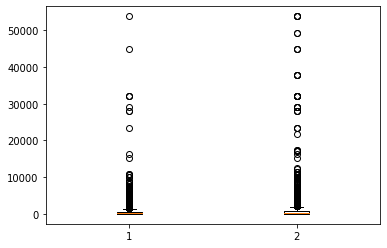

In [102]:
plt.boxplot([train_df[train_df['label']==0]['n1_pop_estimate'], train_df[train_df['label']==1]['n1_pop_estimate']])
plt.show()

In [104]:
train_df[train_df['label']==0]['n2_pop_estimate'].mean(), train_df[train_df['label']==1]['n2_pop_estimate'].mean()

(741.2516372795969, 1052.2441687344913)

# Features for potential edges

In [68]:
with open('results/potential_connections.pkl', 'rb') as fileobj:
    potential_edges = pickle.load(fileobj)

In [69]:
potential_edges[:5]

array([['70201', '71091'],
       ['05019', '05259'],
       ['43321', '28471'],
       ['54049', '54191'],
       ['54651', '54411']], dtype='<U5')

In [70]:
potential_edge_df = get_stop_pair_features(potential_edges)
potential_edge_df.head()

,best_parallelized_time,dist_m,avg_trips,ttt_contribution,ttt_pm,n1_latitude,n2_latitude,n1_longitude,n2_longitude,n1_planningArea,n2_planningArea,n1_avg_flow,n2_avg_flow,n1_pop_estimate,n2_pop_estimate
0,3479.5,17122,5.857143,20100.285714,1.173945,1.324611,1.330734,103.888854,103.903732,GEYLANG,BEDOK,57742,314320,215,1717
1,0.0,233,0.000000,0.000000,0.000000,1.281184,1.279794,103.841050,103.842627,OUTRAM,OUTRAM,61724,17556,180,51
2,0.0,1445,0.000000,0.000000,0.000000,1.349906,1.348111,103.745109,103.732246,BUKIT BATOK,JURONG EAST,78950,34712,492,266
3,0.0,870,0.000000,0.000000,0.000000,1.373505,1.374472,103.845326,103.837564,ANG MO KIO,ANG MO KIO,78304,135326,753,1302
4,0.0,1430,0.000000,0.000000,0.000000,1.378543,1.372353,103.865519,103.854229,SERANGOON,ANG MO KIO,62148,74355,737,715


In [72]:
potential_edge_df['pair'] = list(potential_edges)
potential_edge_df.head()

,best_parallelized_time,dist_m,avg_trips,ttt_contribution,ttt_pm,n1_latitude,n2_latitude,n1_longitude,n2_longitude,n1_planningArea,n2_planningArea,n1_avg_flow,n2_avg_flow,n1_pop_estimate,n2_pop_estimate,pair
0,3479.5,17122,5.857143,20100.285714,1.173945,1.324611,1.330734,103.888854,103.903732,GEYLANG,BEDOK,57742,314320,215,1717,"[70201, 71091]"
1,0.0,233,0.000000,0.000000,0.000000,1.281184,1.279794,103.841050,103.842627,OUTRAM,OUTRAM,61724,17556,180,51,"[05019, 05259]"
2,0.0,1445,0.000000,0.000000,0.000000,1.349906,1.348111,103.745109,103.732246,BUKIT BATOK,JURONG EAST,78950,34712,492,266,"[43321, 28471]"
3,0.0,870,0.000000,0.000000,0.000000,1.373505,1.374472,103.845326,103.837564,ANG MO KIO,ANG MO KIO,78304,135326,753,1302,"[54049, 54191]"
4,0.0,1430,0.000000,0.000000,0.000000,1.378543,1.372353,103.865519,103.854229,SERANGOON,ANG MO KIO,62148,74355,737,715,"[54651, 54411]"


In [73]:
potential_edge_df['n1_planningArea'] = potential_edge_df['n1_planningArea'].astype("string")
potential_edge_df['n2_planningArea'] = potential_edge_df['n2_planningArea'].astype("string")
potential_edge_df.head()

,best_parallelized_time,dist_m,avg_trips,ttt_contribution,ttt_pm,n1_latitude,n2_latitude,n1_longitude,n2_longitude,n1_planningArea,n2_planningArea,n1_avg_flow,n2_avg_flow,n1_pop_estimate,n2_pop_estimate,pair
0,3479.5,17122,5.857143,20100.285714,1.173945,1.324611,1.330734,103.888854,103.903732,GEYLANG,BEDOK,57742,314320,215,1717,"[70201, 71091]"
1,0.0,233,0.000000,0.000000,0.000000,1.281184,1.279794,103.841050,103.842627,OUTRAM,OUTRAM,61724,17556,180,51,"[05019, 05259]"
2,0.0,1445,0.000000,0.000000,0.000000,1.349906,1.348111,103.745109,103.732246,BUKIT BATOK,JURONG EAST,78950,34712,492,266,"[43321, 28471]"
3,0.0,870,0.000000,0.000000,0.000000,1.373505,1.374472,103.845326,103.837564,ANG MO KIO,ANG MO KIO,78304,135326,753,1302,"[54049, 54191]"
4,0.0,1430,0.000000,0.000000,0.000000,1.378543,1.372353,103.865519,103.854229,SERANGOON,ANG MO KIO,62148,74355,737,715,"[54651, 54411]"


In [74]:
potential_edge_df['n1_planningArea'] = area_label_encoder.transform(potential_edge_df['n1_planningArea'])
potential_edge_df['n2_planningArea'] = area_label_encoder.transform(potential_edge_df['n2_planningArea'])
potential_edge_df.head()

,best_parallelized_time,dist_m,avg_trips,ttt_contribution,ttt_pm,n1_latitude,n2_latitude,n1_longitude,n2_longitude,n1_planningArea,n2_planningArea,n1_avg_flow,n2_avg_flow,n1_pop_estimate,n2_pop_estimate,pair
0,3479.5,17122,5.857143,20100.285714,1.173945,1.324611,1.330734,103.888854,103.903732,15,2,57742,314320,215,1717,"[70201, 71091]"
1,0.0,233,0.000000,0.000000,0.000000,1.281184,1.279794,103.841050,103.842627,28,28,61724,17556,180,51,"[05019, 05259]"
2,0.0,1445,0.000000,0.000000,0.000000,1.349906,1.348111,103.745109,103.732246,5,17,78950,34712,492,266,"[43321, 28471]"
3,0.0,870,0.000000,0.000000,0.000000,1.373505,1.374472,103.845326,103.837564,1,1,78304,135326,753,1302,"[54049, 54191]"
4,0.0,1430,0.000000,0.000000,0.000000,1.378543,1.372353,103.865519,103.854229,39,1,62148,74355,737,715,"[54651, 54411]"


In [75]:
potential_edge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 353585 entries, 0 to 353584
Data columns (total 16 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   best_parallelized_time  353585 non-null  float64
 1   dist_m                  353585 non-null  int64  
 2   avg_trips               353585 non-null  float64
 3   ttt_contribution        353585 non-null  float64
 4   ttt_pm                  353585 non-null  float64
 5   n1_latitude             353585 non-null  float64
 6   n2_latitude             353585 non-null  float64
 7   n1_longitude            353585 non-null  float64
 8   n2_longitude            353585 non-null  float64
 9   n1_planningArea         353585 non-null  int32  
 10  n2_planningArea         353585 non-null  int32  
 11  n1_avg_flow             353585 non-null  int64  
 12  n2_avg_flow             353585 non-null  int64  
 13  n1_pop_estimate         353585 non-null  int64  
 14  n2_pop_estimate     

In [76]:
potential_edge_df.to_csv('data/new_link_features.csv', index=False)

In [85]:
potential_edge_df['n1_planningArea'].value_counts()

2     21783
16    21671
44    21014
18    20292
33    16971
38    14731
50    14676
6     14136
15    13316
5     12531
29    12169
1     11232
47    10701
51    10647
39    10462
17     9597
19     9383
37     9313
48     8065
12     7861
13     7188
14     7126
3      6733
26     6335
7      6014
31     5962
32     4966
8      4630
23     3995
4      3864
43     3620
49     2952
45     2942
10     2181
27     1931
35     1794
24     1726
28     1450
0      1427
40     1234
46      955
30      774
34      773
36      728
25      622
9       474
21      344
20      223
22       42
41       15
42       14
Name: n1_planningArea, dtype: int64

In [94]:
area_label_encoder.transform(['JURONG WEST'])

array([18])

# Graph Features

In [81]:
def AppendNextworkxFeature (function, G, X):
    
    column_name = str(function).split()[1]
    tuple_list=[literal_eval(x) for x in X['pair']]
    coef_generator = function(G, tuple_list)
    coef_df = pd.DataFrame(coef_generator)
    X.insert(2, column_name, list(coef_df[2]), allow_duplicates = True)

In [85]:
def nxGenerateFeatures (train_df, test_df):  
    # 1.3 Predict new coefficient/feature for defined link prediction function
    G2 = G.to_undirected()
    linkPredictionFunctions = [nx.resource_allocation_index, nx.jaccard_coefficient, nx.adamic_adar_index, nx.preferential_attachment, ]
    for function in linkPredictionFunctions:
        AppendNextworkxFeature(function, G2, train_df)
        AppendNextworkxFeature(function, G2, test_df)
        
    return train_df, test_df

In [86]:
# train_df, test_df=nxGenerateFeatures(train_df.copy(), test_df.copy())

In [93]:
# train_df['preferential_attachment'].value_counts()

# XGBoost Classifier

In [92]:
train_df=pd.read_csv('data/new_links_train.csv')
test_df=pd.read_csv('data/new_links_test.csv')
train_df

,best_parallelized_time,dist_m,avg_trips,ttt_contribution,ttt_pm,n1_latitude,n2_latitude,n1_longitude,n2_longitude,n1_planningArea,n2_planningArea,n1_avg_flow,n2_avg_flow,n1_pop_estimate,n2_pop_estimate,pair,label
0,0.000000,20039.0,0.000000,0.000000,0.000000,1.374155,1.316623,103.746797,103.917553,12,2,74906,8772,1215,47,"('44871', '83181')",0
1,0.000000,17907.0,0.000000,0.000000,0.000000,1.378526,1.313270,103.753230,103.900496,12,15,18902,18429,306,68,"('44411', '82159')",0
2,62.770966,500.0,828.035714,51803.291892,103.606584,1.284749,1.281770,103.835177,103.838383,6,6,56946,167822,501,1479,"('06049', '06029')",1
3,99.164462,200.0,4.035714,384.852521,1.924263,1.321518,1.319622,103.745809,103.744770,17,17,57898,55677,443,426,"('20269', '20259')",1
4,0.000000,14377.0,0.000000,0.000000,0.000000,1.306340,1.390318,103.814307,103.912943,45,32,20551,59218,103,1404,"('13021', '65521')",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,205.839060,400.0,79.035714,16386.725167,40.966813,1.435077,1.436203,103.800546,103.797396,50,50,115989,68521,1176,694,"('46869', '46859')",1
7996,0.000000,27111.0,0.000000,0.000000,0.000000,1.301779,1.390966,103.752844,103.979769,17,10,6824,434,52,0,"('29081', '99091')",0
7997,90.629519,400.0,57.750000,5065.460656,12.663652,1.273273,1.275847,103.812471,103.815157,6,6,94275,35365,830,311,"('14041', '14051')",1
7998,0.000000,7180.0,0.000000,0.000000,0.000000,1.378363,1.371908,103.847225,103.911429,1,30,18702,12352,180,0,"('55321', '64161')",0


model1 = Distance, Location and Population Estimate  
model2 = Distance, Location and Average Flow  
model3 = Distance and Population Estimate  
model4 = Distance and Average Flow


In [82]:
import xgboost

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier



In [96]:
def XGB(X_train, X_test, y_train, y_test, LR = 0.1, n_est = 1000, max_d = 5, min_c = 1, gm = 0, colsample = 0.8, subs = 1, lambd = 0, alpha = 0):
       
    xgb_model = XGBClassifier( learning_rate=LR, 
                                            n_estimators=n_est,
                                            max_depth=max_d,
                                            min_child_weight=min_c,                         
                                            gamma=gm,
                                            colsample_bytree=colsample,
                                            subsample=subs,
                                            objective ='binary:logistic',                   
                                            reg_lambda=lambd,
                                            reg_alpha=alpha,
                                            scale_pos_weight = 1,
                                            seed=42)


    xgb_model.fit(X_train,y_train)
    y_pred_train = xgb_model.predict(X_train)
    y_pred = xgb_model.predict(X_test)

    # print(y_test)
    # print(y_pred)
    print('performance over the training set: ' + str(f1_score(y_train, y_pred_train)))
    print('performance over the test set: ' + str(f1_score(y_test, y_pred)) + '\n')
    print(classification_report(y_test, y_pred))
    return xgb_model

In [123]:
y_train=train_df['label']
y_test=test_df['label']

In [124]:
X_train=train_df[['dist_m', 'n1_latitude', 'n1_longitude', 'n2_latitude', 'n2_longitude', 'n1_pop_estimate', 'n2_pop_estimate']]
X_test=test_df[['dist_m', 'n1_latitude', 'n1_longitude', 'n2_latitude', 'n2_longitude', 'n1_pop_estimate', 'n2_pop_estimate']]
model1 = XGB(X_train, X_test, y_train, y_test)

performance over the training set: 1.0
performance over the test set: 0.9746245468669084

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1030
           1       0.98      0.97      0.97       970

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000



In [125]:
X_train=train_df[['dist_m', 'n1_latitude', 'n1_longitude', 'n2_latitude', 'n2_longitude', 'n1_avg_flow', 'n2_avg_flow']]
X_test=test_df[['dist_m', 'n1_latitude', 'n1_longitude', 'n2_latitude', 'n2_longitude', 'n1_avg_flow', 'n2_avg_flow']]
model2 = XGB(X_train, X_test, y_train, y_test)


performance over the training set: 1.0
performance over the test set: 0.975635044064282

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1030
           1       0.98      0.97      0.98       970

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000



In [126]:
X_train=train_df[['dist_m', 'n1_pop_estimate', 'n2_pop_estimate']]
X_test=test_df[['dist_m', 'n1_pop_estimate', 'n2_pop_estimate']]
model3 = XGB(X_train, X_test, y_train, y_test)

performance over the training set: 0.9972630007464544
performance over the test set: 0.9625779625779626

              precision    recall  f1-score   support

           0       0.96      0.97      0.97      1030
           1       0.97      0.95      0.96       970

    accuracy                           0.96      2000
   macro avg       0.96      0.96      0.96      2000
weighted avg       0.96      0.96      0.96      2000



In [127]:
X_train=train_df[['dist_m', 'n1_avg_flow', 'n2_avg_flow']]
X_test=test_df[['dist_m', 'n1_avg_flow', 'n2_avg_flow']]
model4 = XGB(X_train, X_test, y_train, y_test)

performance over the training set: 0.9990064580228515
performance over the test set: 0.9687825182101977

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1030
           1       0.98      0.96      0.97       970

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000



In [106]:
predict_df=pd.read_csv("data/new_link_features.csv")
predict_df

,best_parallelized_time,dist_m,avg_trips,ttt_contribution,ttt_pm,n1_latitude,n2_latitude,n1_longitude,n2_longitude,n1_planningArea,n2_planningArea,n1_avg_flow,n2_avg_flow,n1_pop_estimate,n2_pop_estimate,pair
0,3479.5,17122,5.857143,20100.285714,1.173945,1.324611,1.330734,103.888854,103.903732,15,2,57742,314320,215,1717,['70201' '71091']
1,0.0,233,0.000000,0.000000,0.000000,1.281184,1.279794,103.841050,103.842627,28,28,61724,17556,180,51,['05019' '05259']
2,0.0,1445,0.000000,0.000000,0.000000,1.349906,1.348111,103.745109,103.732246,5,17,78950,34712,492,266,['43321' '28471']
3,0.0,870,0.000000,0.000000,0.000000,1.373505,1.374472,103.845326,103.837564,1,1,78304,135326,753,1302,['54049' '54191']
4,0.0,1430,0.000000,0.000000,0.000000,1.378543,1.372353,103.865519,103.854229,39,1,62148,74355,737,715,['54651' '54411']
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353580,4259.0,21578,1.214286,5174.857143,0.239821,1.387683,1.390005,103.978327,103.986755,10,10,2408,6777,1,4,['99071' '99129']
353581,0.0,1192,0.000000,0.000000,0.000000,1.312147,1.301558,103.877150,103.875135,15,19,313294,75775,1168,394,['80069' '80199']
353582,0.0,959,0.000000,0.000000,0.000000,1.293199,1.288964,103.807447,103.814975,33,6,47195,36933,393,325,['11139' '10421']
353583,0.0,988,0.000000,0.000000,0.000000,1.376890,1.374878,103.846172,103.854831,1,1,6161,90314,59,869,['54251' '54579']


In [118]:
pred_df_cols=predict_df[['dist_m', 'n1_latitude', 'n1_longitude', 'n2_latitude', 'n2_longitude', 'n1_avg_flow', 'n2_avg_flow']]

In [120]:
prediction_class=model2.predict(pred_df_cols)
np.unique(prediction_class, return_counts=True)

(array([0, 1]), array([207485, 146100], dtype=int64))

In [121]:
prediction_probs=model2.predict_proba(pred_df_cols)

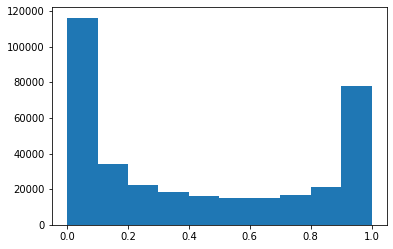

In [122]:
import numpy as np
import matplotlib.pyplot as plt
n, bins, patches = plt.hist(prediction_probs[:,1])
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
n, bins, patches = plt.hist(prediction_probs[:,1])
plt.show()

In [75]:
output_df=pd.DataFrame({'pair':predict_df["pair"], 'prob':prediction_probs[:,1]})

In [77]:
output_df.sort_values(by=["prob"], ascending=False, inplace=True, ignore_index=True)
output_df

,pair,prob
0,['03217' '03241'],1.000000
1,['01549' '01109'],1.000000
2,['14221' '10391'],1.000000
3,['01013' '04019'],1.000000
4,['05429' '05651'],1.000000
...,...,...
353580,['63021' '64211'],0.000005
353581,['63299' '64211'],0.000005
353582,['80089' '90059'],0.000005
353583,['63309' '64211'],0.000004


In [78]:
output_df=output_df[:1000]

In [99]:
output_df.to_csv("results/predicted_links.csv", index=False)

In [ ]:
with open('model1.pkl', "wb") as f:
    pickle.dump(xgb_model, f)